# Loading the SPIDER dataset from HuggingFace

This tutorial will walk you through the steps to download and use the SPIDER dataset.

### Table of Contents

1. [Installing Dependencies](#dependencies)
2. [Loading Demo Dataset](#demo_config)
3. [Visualizing an Example Image](#visualizing_image)
4. [Resizing Images](#resizing)
5. [Loading Original Images](#original_images)
6. [Extracting Metadata](#metadata)
7. [Filtering Scan Types](#filter_scan_type)
8. [Loading Full Dataset](#loading_full_dataset)


### Installing Dependencies <a name="dependencies"></a>

First, install the necessary dependencies:

In [1]:
!pip install datasets -q
!pip install scikit-image -q
!pip install SimpleITK -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 25.5 MB/s eta 0:00:00


In [2]:
import datasets
import skimage
import SimpleITK as sitk

print(f'datasets: {datasets.__version__}')
print(f'scikit-image: {skimage.__version__}')
print(f'SimpleITK: {sitk.__version__}')

datasets: 2.18.0
scikit-image: 0.19.3
SimpleITK: 2.3.1


### Loading the Dataset with Demo Configuration <a name="demo_config"></a>

Next, use the `load_dataset` function from the `datasets` library to download the data directly from the [Zenodo](https://zenodo.org/records/10159290) repository.

Select the `demo` configuration to verify that the function works as intended. The `demo` configuration downloads all of the original `.mha` image and mask files from Zenodo, but only processes the first 10 examples to reduce computation time. The downloaded `.mha` image files will be saved to cache on your local system (which you can set with the `cache_dir` parameter -- see the HuggingFace [docs](https://huggingface.co/docs/datasets/v2.18.0/en/package_reference/loading_methods#datasets.load_dataset)).

Note that in future versions of the `load_dataset` function, you will have to
explicitly pass `trust_remote_code=True` for the code to run. You can review
the source code in the HuggingFace repository [here](https://huggingface.co/datasets/cdoswald/SPIDER/blob/main/SPIDER.py).

In [3]:
from datasets import load_dataset

dataset = load_dataset("cdoswald/SPIDER", name="demo", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Notice that the dataset is split into train, validation, and test subsets, and each example has 8 features: `patient_id`, `scan_type`, `image`, `mask`, `image_path`, `mask_path`, `metadata`, and `rad_gradings`. Only the first 10 examples were processed for this `demo` configuration.

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'scan_type', 'image', 'mask', 'image_path', 'mask_path', 'metadata', 'rad_gradings'],
        num_rows: 10
    })
    validation: Dataset({
        features: ['patient_id', 'scan_type', 'image', 'mask', 'image_path', 'mask_path', 'metadata', 'rad_gradings'],
        num_rows: 10
    })
    test: Dataset({
        features: ['patient_id', 'scan_type', 'image', 'mask', 'image_path', 'mask_path', 'metadata', 'rad_gradings'],
        num_rows: 10
    })
})

### Visualizing an Example Image <a name="visualizing_image"></a>

We can view the features for a specific example by first selecting the data subset (e.g., "train") and then indexing a particular observation:

In [5]:
example = dataset['train'][0]
print(f'Patient ID: {example["patient_id"]}\nScan type: {example["scan_type"]}')

Patient ID: 184
Scan type: t1


By default, the `image` and `mask` attributes will each be 3D volumetric arrays of size `(512, 512, 30)` -- in other words, 30 stacked 512 x 512 grayscale images (note that the channel dimension indicates depth rather than RGB values).

We can select a few specific depths to display as 2D images using matplotlib's `imshow` function:

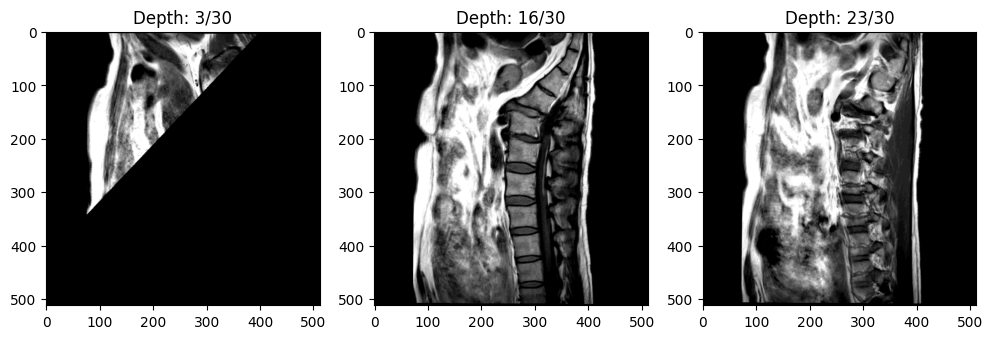

In [6]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 3, figsize=(12, 8))
for j, depth in enumerate([2, 15, 22]):
    ax[j].imshow(np.array(example['image'])[:, :, depth], cmap='gray')
    ax[j].set_title(f'Depth: {depth+1}/30')
plt.show();

We can also overlay the segmentation masks on the images:

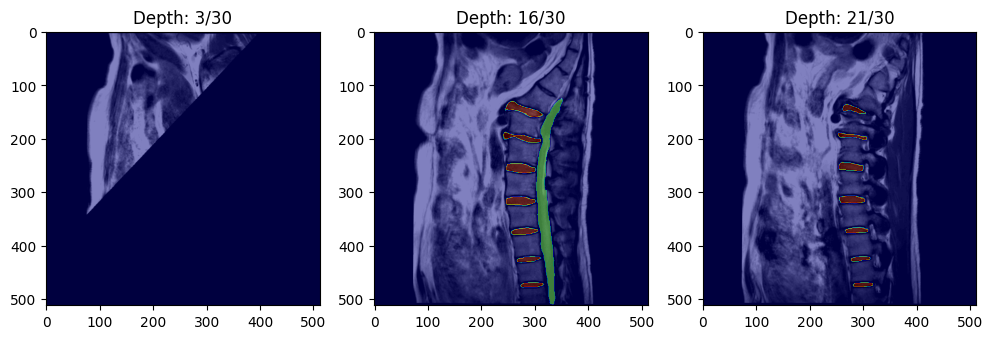

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
for j, depth in enumerate([2, 15, 20]):
    ax[j].imshow(np.array(example['image'])[:, :, depth], cmap='gray')
    ax[j].imshow(np.array(example['mask'])[:, :, depth], alpha=0.5, cmap='jet')
    ax[j].set_title(f'Depth: {depth+1}/30')
plt.show();

### Setting a Custom Resize Shape <a name="resizing"></a>

Notice that the default shape of the example image and mask is `(512, 512, 30)`. Additionally, the resolution (i.e., pixel intensity) is limited to the range `[0, 255]`. The original images vary significantly in size and resolution, and were therefore resized and rescaled to allow the dataset to be loaded via the HuggingFace `datasets` library.

In [8]:
print(f'Image shape: {np.array(example["image"]).shape}')
print(f'Mask shape: {np.array(example["mask"]).shape}')
print(f'Image pixel range: [{np.array(example["image"]).min()}, {np.array(example["image"]).max()}]')
print(f'Mask pixel range: [{np.array(example["mask"]).min()}, {np.array(example["mask"]).max()}]')

Image shape: (512, 512, 30)
Mask shape: (512, 512, 30)
Image pixel range: [0, 24]
Mask pixel range: [0, 2]


If you would prefer a different default size, you can pass a 3-tuple of integers indicating `(height, width, depth)` to the `resize_shape` parameter as follows:



In [9]:
resize_shape = (256, 256, 50)
new_dataset = load_dataset(
    "cdoswald/SPIDER", name="demo", resize_shape=resize_shape, trust_remote_code=True
)

new_example = new_dataset["train"][0]
print(f'New image shape: {np.array(new_example["image"]).shape}')
print(f'New mask shape: {np.array(new_example["mask"]).shape}')

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

New image shape: (256, 256, 50)
New mask shape: (256, 256, 50)


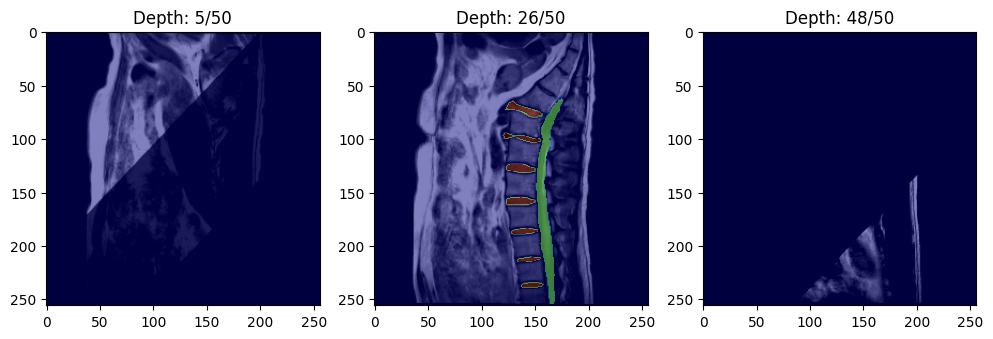

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
for j, depth in enumerate([4, 25, 47]):
    ax[j].imshow(np.array(new_example['image'])[:, :, depth], cmap='gray')
    ax[j].imshow(np.array(new_example['mask'])[:, :, depth], alpha=0.5, cmap='jet')
    ax[j].set_title(f'Depth: {depth+1}/50')
plt.show();

Notice that interpolating along the depth axis can lead to images like that on the left, i.e., where part of the image (the lower right half in this case) is solely the result of the interpolation.

### Loading the Original Images (Size and Resolution) <a name="original_images"></a>

Unfortunately, there is **not** currently a parameter to set a custom resolution. If you would prefer to use the resolution or size of the original images, and/or resize and rescale them to meet your specific requirements, you can import the original image and mask for each example using the `SimpleITK` library:

In [11]:
orig_image = sitk.ReadImage(example['image_path'])
orig_image_array = sitk.GetArrayFromImage(orig_image)

orig_mask = sitk.ReadImage(example['mask_path'])
orig_mask_array = sitk.GetArrayFromImage(orig_mask)

print(f'Original image shape: {orig_image_array.shape}')
print(f'Original mask shape: {orig_mask_array.shape}')

Original image shape: (861, 514, 21)
Original mask shape: (861, 514, 21)


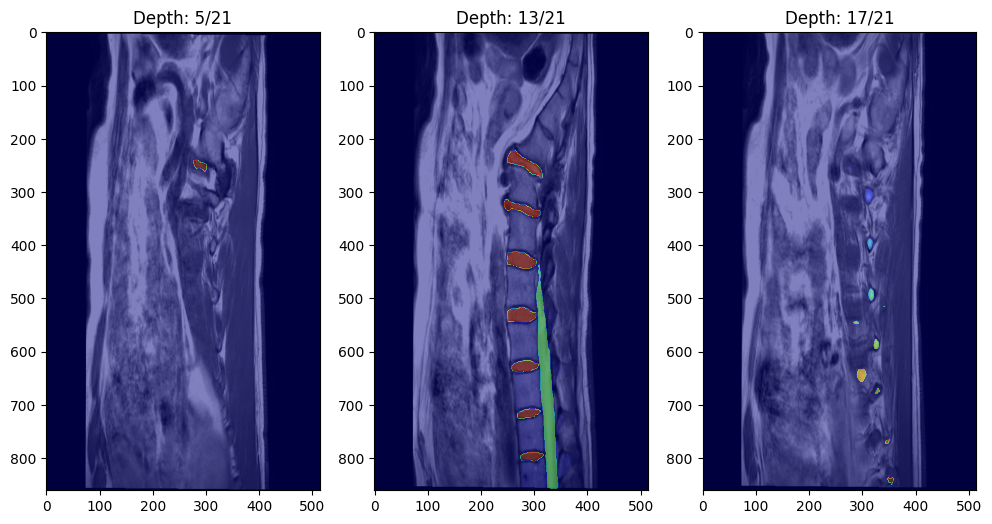

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
for j, depth in enumerate([4, 12, 16]):
    ax[j].imshow(orig_image_array[:, :, depth], cmap='gray')
    ax[j].imshow(orig_mask_array[:, :, depth], alpha=0.5, cmap='jet')
    ax[j].set_title(f'Depth: {depth+1}/{orig_mask_array.shape[-1]}')
plt.show();

### Extracting Metadata <a name="metadata"></a>

In addition to the MRI image and segmentation mask data, each example includes metadata related to the scanner and patient characteristics, when available. You can access this information through the `metadata` feature:

In [13]:
example['metadata']

{'num_vertebrae': 7,
 'num_discs': 7,
 'sex': 'M',
 'birth_date': '',
 'AngioFlag': '',
 'BodyPartExamined': 'MRI LWK',
 'DeviceSerialNumber': '70714.0',
 'EchoNumbers': 1.0,
 'EchoTime': 8.0,
 'EchoTrainLength': 5.0,
 'FlipAngle': 80.0,
 'ImagedNucleus': '1H',
 'ImagingFrequency': 63.87888717651367,
 'InPlanePhaseEncodingDirection': 'COL',
 'MRAcquisitionType': '2D',
 'MagneticFieldStrength': 1.5,
 'Manufacturer': 'Philips Medical Systems',
 'ManufacturerModelName': 'Ingenia',
 'NumberOfPhaseEncodingSteps': 300,
 'PercentPhaseFieldOfView': 139.130443226207,
 'PercentSampling': 90.13806915283199,
 'PhotometricInterpretation': 'MONOCHROME2',
 'PixelBandwidth': 199,
 'PixelSpacing': '[0.47826087474823, 0.47826087474823]',
 'RepetitionTime': 575.0001220703119,
 'SAR': 1.7198117971420201,
 'SamplesPerPixel': 1,
 'ScanningSequence': 'SE',
 'SequenceName': '',
 'SeriesDescription': 'CS T1 TSE SAG',
 'SliceThickness': 4.0,
 'SoftwareVersions': "['5.6.1', '5.6.1.0']",
 'SpacingBetweenSlices': 

Similarly, radiological gradings can be accessed through the `rad_gradings` feature:

In [14]:
example['rad_gradings']

{'IVD label': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 'Modic': ['', '0', '2', '0', '0', '0', '0', '0', '', ''],
 'UP endplate': ['', '1', '1', '0', '0', '0', '0', '0', '', ''],
 'LOW endplate': ['', '1', '1', '0', '0', '0', '0', '0', '', ''],
 'Spondylolisthesis': ['', '1', '0', '0', '0', '0', '0', '0', '', ''],
 'Disc herniation': ['', '0', '0', '0', '0', '0', '0', '0', '', ''],
 'Disc narrowing': ['', '1', '1', '0', '0', '0', '0', '0', '', ''],
 'Disc bulging': ['', '1', '1', '0', '0', '0', '0', '0', '', ''],
 'Pfirrman grade': ['', '4', '5', '1', '1', '1', '1', '1', '', '']}

More information about interpreting the radiological gradings data can be found in the [original paper](https://www.nature.com/articles/s41597-024-03090-w).

### Filtering by Scan Type <a name="filter_scan_type"></a>

The original dataset contains T1, T2, and T2-SPACE [scan types](https://case.edu/med/neurology/NR/MRI%20Basics.htm). You can filter for a subset of scan types by passing a list of the desired types to the `scan_types` parameter:

In [15]:
scan_types = ["t1", "t2"] # Exclude "t2_SPACE" scan types
dataset = load_dataset(
    "cdoswald/SPIDER", name="demo", scan_types=scan_types, trust_remote_code=True
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [16]:
all_scan_types = [example['scan_type'] for example in dataset['train']]
print(f'Unique scan types: {set(all_scan_types)}')

Unique scan types: {'t2', 't1'}


### Loading the Full Dataset <a name="loading_full_dataset"></a>

Finally, you can load all 447 examples (218 patients) using the `default` configuration, changing the other parameters as needed:




In [17]:
dataset = load_dataset(
    "cdoswald/SPIDER",
    name="default", # Default configuration loads all 447 examples
    scan_types=["t1", "t2", "t2_SPACE"], # Default includes all scan types
    resize_shape=(512, 512, 30), # Default resizes images to 512h x 512w x 30d
    trust_remote_code=True,
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]